In [ ]:
import pandas as pd
from tqdm.auto import tqdm, trange
from nltk.parse.corenlp import CoreNLPParser,CoreNLPDependencyParser
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')


In [ ]:
df = pd.read_csv('/scratch/data_jz17d/data/gutenberg/processed/gutenberg_AA_val.csv')

In [ ]:
idxs = [13,44]
texts = []
authors = []
for idx in idxs:
    raw_text = df['text'][idx].split('\n')
    author = df['author_id'][idx]
    print('author', author)
    length = len(raw_text)
    middle_range = (int(0.25*length), int(0.75*length))
    
    text = []
    for sent in raw_text[middle_range[0]:middle_range[1]]:
        if len(sent) > 20 and not sent.isupper():
            text.append(sent.strip(' '))
            authors.append(author)
        if len(text)>1000:
            break
    texts.append(text)
texts = texts[0]+texts[1]

author 452
author 2937


In [ ]:
def get_sent_pos_dist(sentence, token2id, normalize=True, return_list=False, trigram=True):
    if not isinstance(sentence[0], str):
        sentence = [token for sent in sentence for token in sent]
    num_tokens = len(token2id)
    unigram_pos = np.zeros(num_tokens)
    bigram_pos = np.zeros((num_tokens, num_tokens))
    if trigram:
        trigram_pos = np.zeros((num_tokens, num_tokens, num_tokens))

    pprev = 'none'
    prev = 'none'
    for token in sentence:
        unigram_pos[token2id[token]] += 1
        bigram_pos[token2id[prev]][token2id[token]] += 1
        if trigram:
            trigram_pos[token2id[pprev]][token2id[prev]][token2id[token]] += 1
        pprev = prev
        prev = token

    if normalize:
        unigram_pos = unigram_pos/unigram_pos.sum()
        bigram_pos = bigram_pos/bigram_pos.sum()
        if trigram:
            trigram_pos = trigram_pos/trigram_pos.sum()
        
    if return_list:
        if trigram:
            return unigram_pos.tolist(), bigram_pos.tolist(), trigram_pos.tolist()
        return unigram_pos.tolist(), bigram_pos.tolist()
    if trigram:    
        return unigram_pos, bigram_pos, trigram_pos    
    return unigram_pos, bigram_pos

In [ ]:
# https://emorynlp.github.io/nlp4j/components/part-of-speech-tagging.html
xpos_vocab = '''$ 	Dollar 	1.0.0
: 	Colon 	1.0.0
, 	Comma 	1.0.0
. 	Period 	1.0.0
`` 	Left quote 	1.0.0
'' 	Right quote 	1.0.0
-LRB- 	Left bracket 	1.0.0
-RRB- 	Right bracket 	1.0.0
ADD 	Email 	1.0.0
AFX 	Affix 	1.0.0
CC 	Coordinating conjunction 	1.0.0
CD 	Cardinal number 	1.0.0
DT 	Determiner 	1.0.0
EX 	Existential there 	1.0.0
FW 	Foreign word 	1.0.0
GW 	Go with 	1.0.0
HYPH 	Hyphen 	1.0.0
IN 	Preposition or subordinating conjunction 	1.0.0
JJ 	Adjective 	1.0.0
JJR 	Adjective, comparative 	1.0.0
JJS 	Adjective, superlative 	1.0.0
LS 	List item marker 	1.0.0
MD 	Modal 	1.0.0
NFP 	Superfluous punctuation 	1.0.0
NN 	Noun, singular or mass 	1.0.0
NNS 	Noun, plural 	1.0.0
NNP 	Proper noun, singular 	1.0.0
NNPS 	Proper noun, plural 	1.0.0
PDT 	Predeterminer 	1.0.0
POS 	Possessive ending 	1.0.0
PRP 	Personal pronoun 	1.0.0
PRP$ 	Possessive pronoun 	1.0.0
RB 	Adverb 	1.0.0
RBR 	Adverb, comparative 	1.0.0
RBS 	Adverb, superlative 	1.0.0
RP 	Particle 	1.0.0
SYM 	Symbol 	1.0.0
TO 	To 	1.0.0
UH 	Interjection 	1.0.0
VB 	Verb, base form 	1.0.0
VBD 	Verb, past tense 	1.0.0
VBG 	Verb, gerund or present participle 	1.0.0
VBN 	Verb, past participle 	1.0.0
VBP 	Verb, non-3rd person singular present 	1.0.0
VBZ 	Verb, 3rd person singular present 	1.0.0
WDT 	Wh-determiner 	1.0.0
WP 	Wh-pronoun 	1.0.0
WP$ 	Wh-pronoun, possessive 	1.0.0
WRB 	Wh-adverb 	1.0.0
XX'''.split('\n')
for i in range(len(xpos_vocab)):
    xpos_vocab[i] = xpos_vocab[i].split('\t')[0].strip()
xpos_vocab = ['none'] + xpos_vocab
num_xpos_tokens = len(xpos_vocab)
xpos_token2id = {xpos_vocab[i]:i for i in range(num_xpos_tokens)}

In [ ]:
a2i = {452:0, 2937:1}

unigram_dist = [[],[]]
bigram_dist = [[],[]]
trigram_dist = [[],[]]
for x in tqdm(zip(texts, authors)):
    text = x[0]
    tagged = list(pos_tagger.raw_tag_sents([text]))
    pos = []
    for sentence in tagged:
        for word in sentence[0]:
            pos.append(word[1])
    sentence = pos
    author = a2i[x[1]]
#     author -= 2
    unigram_pos, bigram_pos = get_sent_pos_dist(sentence, xpos_token2id, normalize=True, return_list=True, trigram=False)
    unigram_dist[author].append(unigram_pos)
    bigram_dist[author].append(bigram_pos)        
#     trigram_dist[author].append(trigram_pos)  

0it [00:00, ?it/s]

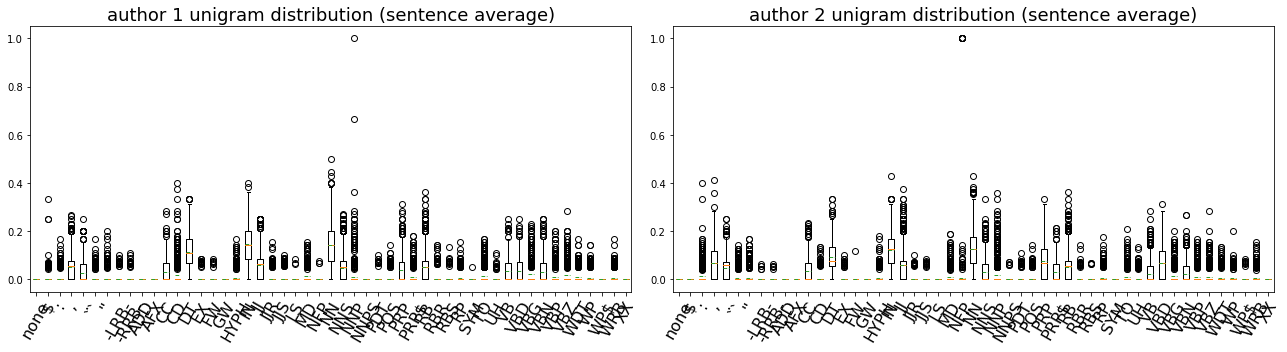

In [ ]:
# author 0, 1
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.boxplot(np.array(unigram_dist[0]), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=60, fontsize=16)
plt.title('author 1 unigram distribution (sentence average)', fontsize=18)
plt.subplot(1,2,2)
plt.boxplot(np.array(unigram_dist[1]), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=60, fontsize=16)
plt.title('author 2 unigram distribution (sentence average)', fontsize=18)
plt.tight_layout()
plt.show()

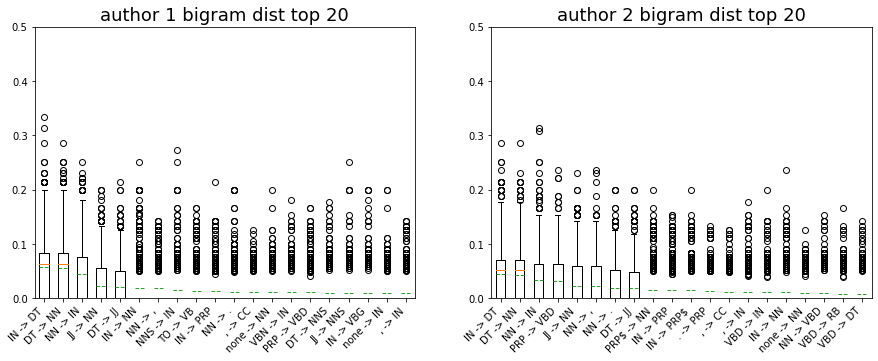

In [ ]:
# author 0, 1
top_n = 20
curr, prev = np.meshgrid(xpos_vocab, xpos_vocab)
prev = prev.reshape(-1)
curr = curr.reshape(-1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bigram_dist_reshaped = np.array(bigram_dist[0]).reshape(len(bigram_dist[0]),-1)
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'author 1 bigram dist top {top_n}', fontsize=18)
plt.ylim(0,0.5)

plt.subplot(1,2,2)
bigram_dist_reshaped = np.array(bigram_dist[1]).reshape(len(bigram_dist[1]),-1)
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'author 2 bigram dist top {top_n}', fontsize=18)
plt.ylim(0,0.5)

plt.show()